# FILTERING THE DATASET:

Along this script we will get from an initial list of products provided by our client, to a final list (as per the names and ids present within the real data), which will be used to filter our initial data in order to get a smaller, more manageable file.

This process will be divided in two main steps:

- Check the names in our list with the descriptions present in our data, analyze them and select a final list

- Use this list to filter our data and store the resulting information in a more small and convenient file

## CREATING THE LIST OF PRODUCTS FOR THE ANALYSIS:

After rearranging the data in a more convenient manner and doing some introductory analysis of the data, we now want to get down to work with our data.

A list has been given to us of the 10 products that our clients found as more relevant to their business.

What we want now is to check whether the names on the list correspond to certain uniques ids, or, as seen in the previous scripts, some conflict of unicity will arise between the id of our products and their descriptions.

So, we are going to check our dataframe and select from it the ids and descriptions of our products that match the indications given in our clients list. With the lists (in reality, two dictionaries) of the ids and descriptions that match every product given to us, we will decide which are the more appropriate.

Perhaps some guidance from our client would be needed at this stage.

### 1. Read dataframe

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math
import seaborn as sns


%matplotlib inline
pd.options.display.max_columns = None

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [219]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" # 'prueba.csv' 
exit_path = "../../data/02_intermediate/"

filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [13]:
# We create the list of products provided by the client
list_of_products=['croissant',
                  'croissant petit',
                  'tarta mousse 3 chocolates',
                  'tarta de manzana 2º',
                  'palmera de chocolate'
                  'tarta opera',
                  'postre fresas y mascarpone',
                  'milhojas frambuesa 2º',
                  'tortel',
                  'baguette']

In [317]:
# We import the dataframe:
df=pd.read_csv(file_path+file_name, sep=sep)

In [318]:
df.sample(5)

product_id                        description          order_date  \
11999272       532.0           FRUTA GLASEADA MELOCOTON  11/12/2010 0:00:00   
28260845       289.0  BOLSA DE PALITOS HOJADRE VARIADOS    1/4/2008 0:00:00   
10755993       365.0                  GALANTINA DE PATO   31/8/2013 0:00:00   
13548830       217.0       PASTELITOS CHISTORRA COCIDOS   18/5/2010 0:00:00   
13544798       653.0        PAN DE BRIOCH BOLSA 275 GRS   24/6/2010 0:00:00   

          section store units_ordered  
11999272        0  AeUP          0,00  
28260845        0  ZiUO          0,00  
10755993        0  RzUP          0,00  
13548830        0  LiUP          0,00  
13544798        0  LiUP          0,00

### 2. Normalizing and aggregating description names

Unfortunately, there is no convention for the description and one id could 

1. Normalize descriptions as much as possible using:
    - Regex expressions 
    - Basic NLP for spell-checking.
2. Create a normalization file with the following structure:
    - Unique Product_id and normalized description
    - Flag to indicate if the product is part of the given list, or not.  
3. Finally review the list manually. 

### 2.1 Normalizing description names 

In [319]:
# Setting Null descriptions to 'no-description'
df['description'].fillna('no-description', inplace = True)

# Unique product descriptions
df_descriptions_unique = pd.Series(df['description'].unique())

# Most of the descriptions are in uppercase, however others are in lower:
df_descriptions_normalized = df_descriptions_unique.str.lower()

#replace non alfanumeric with space
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'[^0-9a-zA-Zº()ª:-]+', ' ') 

# We also notice that there are spacing issues at the begining, end of the description and between words:
df_descriptions_normalized=df_descriptions_normalized.str.strip()

# Remove multi-spacing. multi '-' and multi ':'
df_descriptions_normalized=df_descriptions_normalized.str.replace(r' +', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'-+', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r':+', ' ') 

In [320]:
pd.DataFrame(dict(desc_original = df_descriptions_unique, desc_normalized = df_descriptions_normalized)).sample(10)

desc_original  \
46126  SELVA NEGRA 3ºsin raspadura y con chocolatina ...   
9086            EncargoTARTA MOUSE DE TRES CHOCOLATES 4-   
42494      Encargo Pirámide de macaron de 40 cm de alto.   
46254  TARTA FRESAS Y MASCARPONE 2º CON CARTEL " Feli...   
6616          CARTEL PARA TARTA DE: FELICIDADES 18 PAULA   
10015                        FRESON  DE CHOCOLATE FUTBOL   
21623                                   BLANDADA BACALAO   
32098                    BROCHETAS DE LANGOSTINO Y JAMON   
1064                                  EMPANADILLA SALMON   
7754           MOUSSE 3  CHOCOLATES 1º FELIZ ANIVERSARIO   

                                         desc_normalized  
46126  selva negra 3ºsin raspadura y con chocolatina ...  
9086            encargotarta mouse de tres chocolates 4   
42494       encargo pir mide de macaron de 40 cm de alto  
46254  tarta fresas y mascarpone 2º con cartel felici...  
6616          cartel para tarta de  felicidades 18 paula  
10015                         freson de chocolate futbol  
21623                                   blandada bacalao  
32098                    brochetas de langostino y jamon  
1064                                  empanadilla salmon  
7754            mousse 3 chocolates 1º feliz aniversario

Now lets gets get our hands dirty and apply some maths to calculate string distnace and finish cleaning all those messy product descriptions... This is what we are going to do:

1. Create a dataset with pastry products by parsing the bakery catalogues, and other pastry websites. (this was done manually, by converting the pdf catalogues to txt using an external web. THe resulting file is named productos.txt)

2. Following the indications from: https://medium.com/@hdezfloresmiguelangel/implementando-un-corrector-ortogr%C3%A1fico-en-python-utilizando-la-distancia-de-levenshtein-498ec0dd1105 create an spell-checker based on the products.txt dataset and the Levenshtein distance


In [321]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../../data/01_additional_data/productos.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [322]:
correction("trta")

'tarta'

In [323]:
correction("café")

'cafe'

Fantastic! the it seems to work. Lets now apply it to our dataset:

In [324]:
def spell_check (line):
    "Given a sentence, returns spell-checks word by word"
    if type(line) == str and len(line) > 0:
        new = []
        line = line.split(" ")
        for word in line:
            if type(word) == str:
                word = correction(word)
            new.append(word)
        return " ".join(new)
            
    else:
        return line

In [325]:
# CAUTION! The following cell e may take a long time to process (5 hours): 

# spell-check word by word the dataset:
df_descriptions_normalized = df_descriptions_normalized.apply(lambda line: spell_check(line))

Lets now merge the normalized names back to the original file, and check how effective was this cleaning:

In [326]:
to_merge = pd.DataFrame(dict(description = df_descriptions_unique, desc_normalized = df_descriptions_normalized))

df_with_normalized_descriptions_transactions = pd.merge(df, to_merge, how='left', on = 'description').sort_values(by='order_date')
df_with_normalized_descriptions_transactions.sample(5)

product_id                              description  \
21232488       237.0             COCA DE VERDURAS Y MOZARELLA   
3036047        462.0                               MANZANA 2º   
12815242       295.0                   TARTA QUICHE ESPINACAS   
731753         609.0                                     COCO   
196097        3341.0  BERENJENAS RELLENAS DE POULARDA Y SETAS   

                  order_date  section store units_ordered  \
21232488   29/1/2017 0:00:00        0  MoUP          0,00   
3036047    10/9/2015 0:00:00        0  VeUp          1,00   
12815242   19/4/2018 0:00:00        0  AeUP          0,00   
731753     15/6/2010 0:00:00        0  BmUP          0,00   
196097    22/12/2012 0:00:00        0  BmUP          1,00   

                                  desc_normalized  
21232488             con de verduras y mozzarella  
3036047                                 manzana 2  
12815242                   tarta quiche espinacas  
731753                                      choco  
196097    berenjenas rellenos de poularda y setas

In [327]:
#Control merge size:
if (df.shape[0] == df_with_normalized_descriptions_transactions.shape[0] ): 
    test0 = "OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test0 = "ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' "
print(test0)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 


In [328]:
# Checking effectiveness of the data cleaning:
unique_descriptions_raw = len(df['description'].unique())
unique_descriptions_normalized = len(df_with_normalized_descriptions_transactions['desc_normalized'].unique())
print('The product descritions were cleaned from {} unique names to {}.'.format(unique_descriptions_raw,unique_descriptions_normalized))

The product descritions were cleaned from 48517 unique names to 40020.


Not super effective...

In [329]:
# Saving the file to the intermiady folder
output_path_df_with_normalized_descriptions_transactions = exit_path + 'data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions.to_csv(output_path_df_with_normalized_descriptions_transactions, index = False, sep = ';' )

### 2.2 Identifying product descriptions that the client wants us to predict

It is time to create the file that will be manually reviewed.

- First, we compare the normalized descriptions with the list of products provided with the client, and suggest matches using the library fuzzywuzzy
- Second, we will use the results from the other analysis.
- third, we will manually evaluate if the results are good

#### 2.2.1 Using the library fuzzywuzzy to compare the product normalized descriptions with the list of products provided by the client and suggest a match, or alternatively - "match-not-found"

In [330]:
df_normalized_desc_unique = pd.DataFrame(df_with_normalized_descriptions_transactions["desc_normalized"].unique(), columns = ['desc_normalized'])

In [331]:
def find_match (line, options = list_of_products):
    "Returns product match if the the calculated difference between strings is greater than 80, 'match-not-found' otherwise"
    if not(line is None) and type(line)== str:
        highest = process.extractOne(line,list_of_products)
        if not(highest is None) and highest[1] >80:
            return highest[0]
        else:
            return 'match-not-found'
    else:
        return 'match-not-found'

# Applying matching function to all product normalized descriptions
df_normalized_desc_unique["target_names_fuzzywuuzy"] = df_normalized_desc_unique["desc_normalized"].apply(lambda line: find_match(line))

Lets now evaluate how effectively did we match the normalized descriptions with the list that the client provided us:

In [332]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_desc_unique[df_normalized_desc_unique['desc_normalized'].str.contains('mousse')].head(10)

desc_normalized          target_names_fuzzywuuzy
380             mousse chocolate blanco                  match-not-found
417  postres mousse chocolate en vasito                  match-not-found
419        postres mousse frutas bosque                  match-not-found
483             postres mousse de limon                  match-not-found
502          petit yogur mousse praline                  croissant petit
570               mousse 3 chocolates 3        tarta mousse 3 chocolates
571               mousse 3 chocolates 1        tarta mousse 3 chocolates
572               mousse 3 chocolates 2        tarta mousse 3 chocolates
573      postres mousse tres chocolates                  match-not-found
618                   mousse de perigot  palmera de chocolatetarta opera

As we can see... its not actually very good, lets try something different.

#### 2.2.1 Using the results from the other analysis

Lets now use the results from the manual analysis to see how efective the measure was:

In [333]:
# Since this matching is performed at id level, 
# lets create a new dataset with unique product_id, descriptions, and evaluate it:
df_normalized_id_desc_unique = df_with_normalized_descriptions_transactions[["product_id",'desc_normalized']].drop_duplicates()

In [334]:
dict_of_products_matches={100: 'croissant', 
                  101: 'croissant',
                  102: 'croissant',
                  103: 'croissant petit',
                  9999: 'tarta mousse 3 chocolates', # almost only for order, creating a new id for this product is suggested
                  462: 'tarta de manzana 2º',
                  182: 'palmera de chocolate', # palmeras: 140
                  414: 'tarta opera', # 9999, for order, mostly. If included, creating a new id for this product is suggested
                  4511:'postre fresas y mascarpone',
                  459: 'milhojas frambuesa 2º',
                  112: 'tortel',
                  115: 'baguette'}

In [335]:
def target_names_a(product_id, dict_of_products_matches= dict_of_products_matches):
    'Returns match if the product_id is found within the given dict or, otherise "match-not-found"'
    if not(product_id is None) and not(math.isnan(product_id)) and int(product_id)  in dict_of_products_matches:
        return dict_of_products_matches[int(product_id)]
    else:
        return 'match-not-found'

df_normalized_id_desc_unique['target_names_manual_analysis']=df_normalized_id_desc_unique["product_id"].apply(lambda line: target_names_a(line))

Lets now check how effective this was:

In [336]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_id_desc_unique[df_normalized_id_desc_unique['desc_normalized'].str.contains('mousse')].head(15)

product_id                     desc_normalized  \
2498667        618.0             mousse chocolate blanco   
2479507        877.0  postres mousse chocolate en vasito   
2479509        879.0        postres mousse frutas bosque   
13734845       821.0             postres mousse de limon   
13734826       728.0          petit yogur mousse praline   
25009569       453.0               mousse 3 chocolates 3   
25009568       452.0               mousse 3 chocolates 1   
25009567       451.0               mousse 3 chocolates 2   
25009566       450.0      postres mousse tres chocolates   
24921912       312.0                   mousse de perigot   
24921911       311.0                    mousse de salmon   
24921910       310.0                mousse de con opcion   
24921909       309.0                       mousse de con   
21890758       425.0              postres mousse naranja   
21879345       754.0        cartel de mousse de pistacho   

         target_names_manual_analysis  
2498667               match-not-found  
2479507               match-not-found  
2479509               match-not-found  
13734845              match-not-found  
13734826              match-not-found  
25009569              match-not-found  
25009568              match-not-found  
25009567              match-not-found  
25009566              match-not-found  
24921912              match-not-found  
24921911              match-not-found  
24921910              match-not-found  
24921909              match-not-found  
21890758              match-not-found  
21879345              match-not-found

Again, not very good, since most of the 'mousse 3 chocolates' are unmatched.

It is clear that we need an better way to match the results. Lets try doing keywords filtering product by product.

### 2.3 Review Product by Product

In [337]:
#First, lets create again a dataframe with unique descriptions
unique_normalized_decriptions = df_with_normalized_descriptions_transactions[['product_id','desc_normalized']].drop_duplicates()

#And a empty list to add all the unitary analysis. It will be use to concatenate results.
list_of_dfs = []

In [338]:
# Functions that we will use:

def plot_count_per_id(df):
    transactions_by_id = df.groupby("product_id")['desc_normalized'].count()
    transactions_by_id.plot.bar()

#### 2.3.1 Matching: milhojas de frambuesa 2º

In [339]:
def filter_milhojas (df):
    'Filters the product descriptions of given dataset by "milhojas" and "frambuesa 2"'
    milhojas = df[df['desc_normalized'].str.contains('milhojas')]
    milhojas_frambuesa = milhojas[milhojas['desc_normalized'].str.contains('frambuesa 2')].copy()
    return milhojas_frambuesa


In [340]:
# Filter the transactions dataset
milhojas_frambuesa_transacciones=filter_milhojas(df_with_normalized_descriptions_transactions)
milhojas_frambuesa_transacciones.head()

product_id                      description        order_date  \
2498618        414.0  TARTA  MILHOJAS   FRAMBUESA  2º  1/1/2008 0:00:00   
25009572       459.0          MILHOJAS   FRAMBUESA 2º  1/1/2008 0:00:00   
28225388       459.0          MILHOJAS   FRAMBUESA 2º  1/1/2008 0:00:00   
2498860        459.0          MILHOJAS   FRAMBUESA 2º  1/1/2008 0:00:00   
28225146       414.0  TARTA  MILHOJAS   FRAMBUESA  2º  1/1/2008 0:00:00   

          section store units_ordered             desc_normalized  
2498618         0  VeUp          0,00  tarta milhojas frambuesa 2  
25009572        0  MsUP          0,00        milhojas frambuesa 2  
28225388        0  ZiUO          0,00        milhojas frambuesa 2  
2498860         0  VeUp          2,00        milhojas frambuesa 2  
28225146        0  ZiUO          0,00  tarta milhojas frambuesa 2

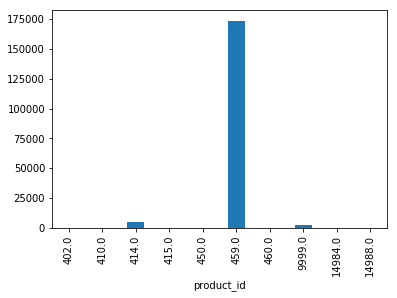

In [341]:
# Plot the ditribution of 'product_id'
plot_count_per_id(milhojas_frambuesa_transacciones)

Lets explore the names distribution of 414, 459 and 9999:

In [342]:
#Names distribution for product_id = 459:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==459.0]['desc_normalized'].value_counts().head()

milhojas frambuesa 2                       167542
milhojas frambuesa 1                         1311
tiras de milhojas rellena solo de crema       532
milhojas frambuesa 3                          437
milhojas frambuesa 2 solo crema               399
Name: desc_normalized, dtype: int64

In [343]:
#Names distribution for product_id = 414:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==414.0]['desc_normalized'].value_counts().head()

tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

In [344]:
#Names distribution for product_id = 9999:
df_with_normalized_descriptions_transactions[(df_with_normalized_descriptions_transactions['product_id']==9999.0) & (df_with_normalized_descriptions_transactions['desc_normalized'].str.contains('milhoja'))]['desc_normalized'].value_counts().head()

tarta milhojas frambuesa 2                  950
tiras de milhojas solo crema                912
encargo tarta milhojas del 1                912
tarta milhojas de frambuesa del 3           855
encargo tarta milhojas y frambuesa del 1    798
Name: desc_normalized, dtype: int64

It seems there is a strong correlation with id 459, however 459 it also includes other types of 'milhojas'. In addition, 'milhojas de frambuesa 2º' is also included in id number 414, which seems to be a multiple 'tartas' id, and id 9999, which is the id used for custom orders.

For these reasons, we decide to filter milhojas based on the description (filtering the dataframe with only disting 'product_id' and 'des_normalized' values:

In [345]:
#Save unique product_id and product_description:
milhojas_frambuesa = filter_milhojas(unique_normalized_decriptions)
milhojas_frambuesa['target_names_prod_by_prod'] = 'milhojas frambuesa'
list_of_dfs.append(milhojas_frambuesa)
milhojas_frambuesa.sample(4)

product_id                                    desc_normalized  \
5283472        459.0       milhojas frambuesa 2 cartel felicidades para   
432879         459.0  milhojas frambuesa 2 con cartel felicidades pilar   
2962403        459.0            milhojas frambuesa 2 felicidades esther   
15696401       459.0  milhojas frambuesa 2 solo de crema con chocola...   

         target_names_prod_by_prod  
5283472         milhojas frambuesa  
432879          milhojas frambuesa  
2962403         milhojas frambuesa  
15696401        milhojas frambuesa

#### 2.3.2 Matching: croissant petite

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant petite' had an strong correlation with id number '103' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [346]:
def filter_croissant_petit (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_petite = croissant[croissant['desc_normalized'].str.contains('petit')].copy()
    return croissant_petite

In [347]:
# Plotting the results:
transactions_croissant_petite = filter_croissant_petit(df_with_normalized_descriptions_transactions)
transactions_croissant_petite.head()

product_id                           description        order_date  \
2498743        103.0                       CROISSANT PETIT  1/1/2008 0:00:00   
2498620        102.0  PETIT  CROISSANTS  ALARGADOS  FUTBOL  1/1/2008 0:00:00   
28225148       102.0  PETIT  CROISSANTS  ALARGADOS  FUTBOL  1/1/2008 0:00:00   
28225271       103.0                       CROISSANT PETIT  1/1/2008 0:00:00   
12146191       103.0                       CROISSANT PETIT  1/1/2008 0:00:00   

          section store units_ordered                   desc_normalized  
2498743         0  VeUp         18,00                   croissant petit  
2498620         0  VeUp          0,00  petit croissant alargados futbol  
28225148        0  ZiUO          0,00  petit croissant alargados futbol  
28225271        0  ZiUO          0,00                   croissant petit  
12146191        0  AeUP          0,00                   croissant petit

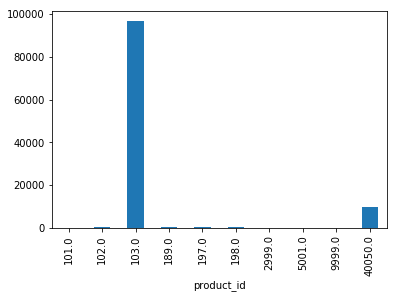

In [348]:
plot_count_per_id(transactions_croissant_petite)

It is clear that id '103' represents the 'croissant petite';  in fact, after reviweing the data with the client, he suggested only taking 103.

In [349]:
# Saving id=103 as croissant petit
croissant_petit = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==103.0].copy()
croissant_petit['target_names_prod_by_prod'] = 'croissant petit'
list_of_dfs.append(croissant_petit)
croissant_petit.head()

product_id             desc_normalized target_names_prod_by_prod
2498743        103.0             croissant petit           croissant petit
2498613        103.0      mini napolitanas crema           croissant petit
2498614        103.0  mini napolitanas chocolate           croissant petit
2498615        103.0            focaccias futbol           croissant petit
23088161       103.0        baguet multicereales           croissant petit

#### 2.3.3 Matching: croissant

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant simple' had an strong correlation with id number '100' and '101' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [350]:
def filter_croissant_simple (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_simple = croissant[~croissant['desc_normalized'].str.contains('petit|tira|masa')].copy()
    return croissant_simple

In [351]:
transactions_croissant_simple = filter_croissant_simple(df_with_normalized_descriptions_transactions)
transactions_croissant_simple.head()

product_id                     description        order_date  \
2498726       215.0  CROISANNT SOBRASADA PQ COCIDOS  1/1/2008 0:00:00   
2498740       100.0                       CROISANTS  1/1/2008 0:00:00   
2498741       101.0                       CROISSANT  1/1/2008 0:00:00   
2498742       102.0               CROISSANT FRANCES  1/1/2008 0:00:00   
2498744       105.0             CROISSANT CHOCOLATE  1/1/2008 0:00:00   

         section store units_ordered                desc_normalized  
2498726        0  VeUp          2,00  croissant sobrasada px cocido  
2498740        0  VeUp         20,00                      croissant  
2498741        0  VeUp          0,00                      croissant  
2498742        0  VeUp         10,00             croissant francesa  
2498744        0  VeUp          1,00            croissant chocolate

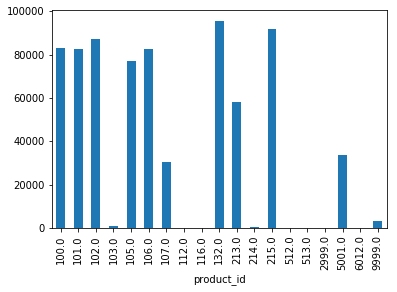

In [352]:
plot_count_per_id(transactions_croissant_simple)

Interesting, the correlation seems to exsit for several ids... Lets explore a bit more... Lets plot the most common description from each id and see if we find any pattern:

In [353]:
for i in transactions_croissant_simple['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 215.0 
-
croissant sobrasada px cocido                             91580
croissant sobrasada px cocido de encargo                     76
croissant sobrasada px cocido encargo                        38
croissant sobrasada px cocido manda con fuet n del pan       19
mini pizzas                                                  19
Name: desc_normalized, dtype: int64

***Plotting id: 100.0 
-
croissant                       80598
croissant normal mango           1197
croissant alargados piezas        342
croissant piezas alargadas        133
croissant alargados y piezas       95
Name: desc_normalized, dtype: int64

***Plotting id: 101.0 
-
croissant                        72124
croissant andes marcos piezas     8550
suizos piezas hacer 10            4180
ensaimadas piezas hacer 10        3477
tiras de focaccias                2432
Name: desc_normalized, dtype: int64

***Plotting id: 102.0 
-
croissant francesa               86279
croissant andes marcos piezas      703
focacc

It seems that they have different types of croissant. Checking with the client, he suggested taking only: 100.0 and 101.0 that contains the word 'croissant'

In [354]:
croissant_simple = unique_normalized_decriptions[(unique_normalized_decriptions['product_id']==100.0)|(unique_normalized_decriptions['product_id']==101.0)].copy()
croissant_simple = croissant_simple[croissant_simple['desc_normalized'].str.contains('croissant')]
croissant_simple = croissant_simple[~croissant_simple['desc_normalized'].str.contains('petit|tira|masa')].copy()

croissant_simple['target_names_prod_by_prod'] = 'croissant simple'
list_of_dfs.append(croissant_simple)
croissant_simple.head()

product_id                   desc_normalized  \
2498740        100.0                         croissant   
2498741        101.0                         croissant   
13838645       101.0     croissant andes marcos piezas   
23088164       101.0  croissant alargados andes piezas   
10652311       101.0         croissant alargados andes   

         target_names_prod_by_prod  
2498740           croissant simple  
2498741           croissant simple  
13838645          croissant simple  
23088164          croissant simple  
10652311          croissant simple

#### 2.3.4 Matching: tarta mousse tres chocolates

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'mousse tres chocolates' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [355]:
def filter_mousse_tres_chocolates (df):
    tarta = df[df['desc_normalized'].str.contains('tarta')].copy()
    mousse = tarta[tarta['desc_normalized'].str.contains('mousse|mus')].copy()
    mousse_tres = mousse[mousse['desc_normalized'].str.contains('tres|3')].copy()
    mousse_tres = mousse_tres[~mousse_tres['desc_normalized'].str.contains('mini')].copy()
    mousse_tres_chocolates = mousse_tres[mousse_tres['desc_normalized'].str.contains('chocolate')].copy()
    return mousse_tres_chocolates

In [356]:
transactions_mousse_tres_chocolates = filter_mousse_tres_chocolates(df_with_normalized_descriptions_transactions)
transactions_mousse_tres_chocolates.head()

product_id                       description        order_date  \
2498617        414.0  TARTA  MUS  TRES  CHOCOLATES  2º  1/1/2008 0:00:00   
28225145       414.0  TARTA  MUS  TRES  CHOCOLATES  2º  1/1/2008 0:00:00   
12146065       414.0  TARTA  MUS  TRES  CHOCOLATES  2º  1/1/2008 0:00:00   
5714433        414.0  TARTA  MUS  TRES  CHOCOLATES  2º  1/1/2008 0:00:00   
13753973       414.0  TARTA  MUS  TRES  CHOCOLATES  2º  1/1/2008 0:00:00   

          section store units_ordered              desc_normalized  
2498617         0  VeUp          0,00  tarta mus tres chocolates 2  
28225145        0  ZiUO          0,00  tarta mus tres chocolates 2  
12146065        0  AeUP          0,00  tarta mus tres chocolates 2  
5714433         0  AaUP          0,00  tarta mus tres chocolates 2  
13753973        0  LiUP          0,00  tarta mus tres chocolates 2

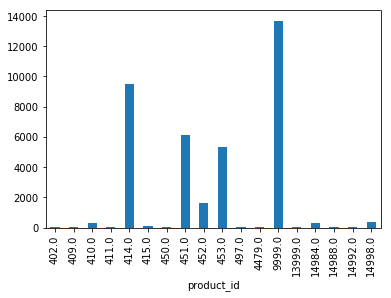

In [357]:
plot_count_per_id(transactions_mousse_tres_chocolates)

Lets explore it more by having a look at the full distribution of names:

In [358]:
for i in transactions_mousse_tres_chocolates['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 414.0 
-
tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 451.0 
-
mousse 3 chocolates 2                                    167333
mousse 3 chocolates 2 una de encargo                        266
mousse 3 chocolates 4                                       133
mousse 3 chocolates 2 encargo                               133
mousse 3 chocolates 2 escrito en la tarta felicidades       114
Name: desc_normalized, dtype: int64

***Plotting id: 453.0 
-
mousse 3 chocolates 3               128003
mousse 3 chocolates 4                  589
mousse 3 chocolates 3 

It seems that 'tarta mousse tres chocolates' is all over the place... So the easiest is to filter by product description"

In [359]:
mousse_tres_chocolates = filter_mousse_tres_chocolates(unique_normalized_decriptions)
mousse_tres_chocolates['target_names_prod_by_prod'] = 'mousse tres chocolates'
list_of_dfs.append(mousse_tres_chocolates)
mousse_tres_chocolates.head()

product_id                                    desc_normalized  \
2498617        414.0                        tarta mus tres chocolates 2   
15446586      9999.0  tarta mousse 3 chocolates 3 escrito sobre la t...   
2190335       9999.0  tarta mousse 3 chocolates del segun escrito so...   
18702883       451.0  mousse 3 chocolates 2 escrito sobre la tarta f...   
18702879      9999.0  encargo tarta mousse 3 chocolates del 4 sandra...   

         target_names_prod_by_prod  
2498617     mousse tres chocolates  
15446586    mousse tres chocolates  
2190335     mousse tres chocolates  
18702883    mousse tres chocolates  
18702879    mousse tres chocolates

#### 2.3.5 Matching: tarta de manzana 2
From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'tarta de manzana 2' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [360]:
def filter_tarta_manzana_2 (df):
    manzana_tarta = df[df['desc_normalized'].str.contains('manzana')]
    #manzana_tarta = manzana[manzana['desc_normalized'].str.contains('tarta')].copy() #Removed because we saw it had better fit
    manzana_tarta = manzana_tarta[~manzana_tarta['desc_normalized'].str.contains('caramelo')].copy()
    manzana_tarta_dos = manzana_tarta[manzana_tarta['desc_normalized'].str.contains('dos|2')].copy()

    return manzana_tarta_dos

In [361]:
transactions_manzana_tarta_dos=filter_tarta_manzana_2(df_with_normalized_descriptions_transactions)

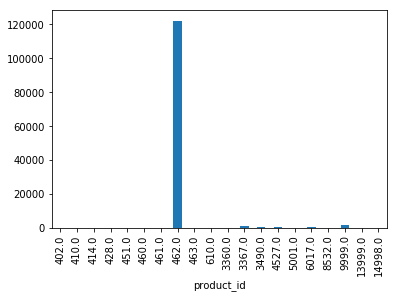

In [362]:
plot_count_per_id(transactions_manzana_tarta_dos)

Looks like we found a winner!

In [363]:
manzana_tarta_dos = filter_tarta_manzana_2(unique_normalized_decriptions)
manzana_tarta_dos['target_names_prod_by_prod'] = 'tarta de manzana'
list_of_dfs.append(manzana_tarta_dos)
manzana_tarta_dos.head()

product_id                      desc_normalized  \
16860288       462.0                            manzana 2   
8269309       5001.0                manzana caramelizados   
16945040      9999.0           encargotarta manzana del 2   
19093062      9999.0          encargo tarta manzana del 2   
9457692        462.0  manzana 2 cartelfelicidades inmanol   

         target_names_prod_by_prod  
16860288          tarta de manzana  
8269309           tarta de manzana  
16945040          tarta de manzana  
19093062          tarta de manzana  
9457692           tarta de manzana

#### 2.3.6 Matching: palmera de chocolate 

In [364]:
def filter_palmera_chocolate (df):
    palmera = df[df['desc_normalized'].str.contains('palmera')]
    palmera_chocolate = palmera[palmera['desc_normalized'].str.contains('chocolate|trufa')].copy() #Added trufa after reviwing results
    return palmera_chocolate

In [365]:
transactions_palmera_chocolate = filter_palmera_chocolate(df_with_normalized_descriptions_transactions)
transactions_palmera_chocolate.head()

product_id        description        order_date  section store  \
2498711        182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  VeUp   
28225239       182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  ZiUO   
12146159       182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  AeUP   
13754067       182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  LiUP   
10538251       182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  RzUP   

         units_ordered   desc_normalized  
2498711           4,00  palmera de trufa  
28225239          0,00  palmera de trufa  
12146159          0,00  palmera de trufa  
13754067          0,00  palmera de trufa  
10538251          2,00  palmera de trufa

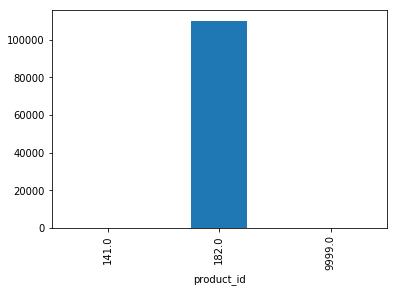

In [366]:
plot_count_per_id(transactions_palmera_chocolate)

Again, we have a winner!

In [367]:
palmera_chocolate = filter_palmera_chocolate(unique_normalized_decriptions)
palmera_chocolate['target_names_prod_by_prod'] = 'palmera chocolate'

list_of_dfs.append(palmera_chocolate)
palmera_chocolate.head()

product_id                                    desc_normalized  \
2498711        182.0                                   palmera de trufa   
27157220       182.0                          palmera de trufa (piezas)   
18197068       182.0       palmera de trufa manda con el furgon del pan   
1772413        182.0  palmera de trufa y y unidades y y encargo para...   
16035802       182.0                     palmera de trufa primer fuet n   

         target_names_prod_by_prod  
2498711          palmera chocolate  
27157220         palmera chocolate  
18197068         palmera chocolate  
1772413          palmera chocolate  
16035802         palmera chocolate

#### 2.3.7 Matching: tarta ópera 

In [368]:
def filter_tarta_opera(df):
    opera = df[df['desc_normalized'].str.contains('opera')]
    opera_tarta = opera[opera['desc_normalized'].str.contains('tarta')].copy()
    return opera_tarta

In [369]:
transactions_tarta_opera = filter_tarta_opera(df_with_normalized_descriptions_transactions)

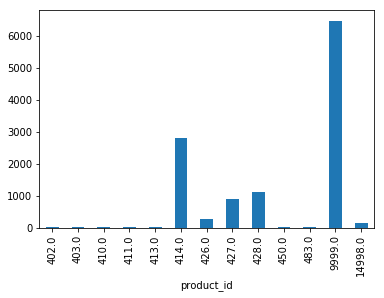

In [370]:
plot_count_per_id(transactions_tarta_opera)

In [371]:
for i in transactions_tarta_opera['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 414.0 
-
tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

***Plotting id: 14998.0 
-
tarta saint honore del 4                                                     38
tartas especiales de 10 de mickey de 12 la con el bizcocho de selva negra    38
tartas especiales                                                            38
tarta mousse de tres chocolates del 4                                        38
tarta milhojas de frambuesa del 1                                            19
Name: desc_normalized, dtype: int64

***Plotting id: 427.0 
-
opera 3                   

Again, all over the place, so we decided to use the description filter:

In [372]:
tarta_opera = filter_tarta_opera(unique_normalized_decriptions)
tarta_opera['target_names_prod_by_prod'] = 'tarta opera'

list_of_dfs.append(tarta_opera)
tarta_opera.head()

product_id            desc_normalized target_names_prod_by_prod
16861201      9999.0          tarta opera del 3               tarta opera
15446585      9999.0          tarta opera del 4               tarta opera
6793103        414.0              tarta opera 2               tarta opera
25734280      9999.0  encargo tarta opera del 5               tarta opera
25734279      9999.0  encargo tarta opera del 8               tarta opera

#### 2.3.9 Matching: postre de fresas y mascarpone

In [373]:
def filter_postre_fresas_mascarpone (df):
    postre = df[df['desc_normalized'].str.contains('postre')]
    postre_fresa = postre[postre['desc_normalized'].str.contains('fresa')].copy()
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('eclair')].copy() #Client indication
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('tartaleta')].copy() #Client indication

    postre_fresa_mascarpone = postre_fresa[postre_fresa['desc_normalized'].str.contains('mascarpone')].copy()
    return postre_fresa_mascarpone

In [374]:
transactions_postre_fresas_mascarpone = filter_postre_fresas_mascarpone(df_with_normalized_descriptions_transactions)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


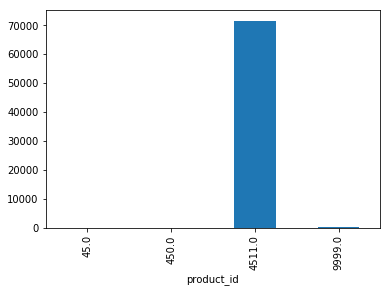

In [375]:
plot_count_per_id(transactions_postre_fresas_mascarpone)

In [376]:
for i in transactions_postre_fresas_mascarpone['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 4511.0 
-
postres fresas y mascarpone                 71402
postres tartaleta fresas y mascarpone         684
postres fresas y mascarpone encargo de         38
postres fresas y mascarpone encargo line       38
postres fresas y mascarpone para feo           19
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 450.0 
-
postres mousse tres chocolates      82403
postres selva negra                  3116
postres milhojas frambuesa           2926
mini postres mus tres chocolates     2014
postres milhojas                     1976
Name: desc_normalized, dtype: int64

***Plotting id: 45.0 
-
postres mousse tres chocolates    34865
postres san marcos                  608
postres selva negra                 361
postres cheesecake          

Seems that the filter is working :)

In [377]:
postre_fresas_mascarpone = filter_postre_fresas_mascarpone(unique_normalized_decriptions)

postre_fresas_mascarpone['target_names_prod_by_prod'] = 'postre de fresas y mascarpone'
list_of_dfs.append(postre_fresas_mascarpone)
postre_fresas_mascarpone.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


product_id                                    desc_normalized  \
8269689       4511.0                        postres fresas y mascarpone   
26029451      9999.0  encargo 1 postres de cada de breton milhojas l...   
1772420       9999.0              encargo postres de fresa y mascarpone   
5133052       9999.0                         postres fresa y mascarpone   
29700352      9999.0                   encargopostre fresa y mascarpone   

              target_names_prod_by_prod  
8269689   postre de fresas y mascarpone  
26029451  postre de fresas y mascarpone  
1772420   postre de fresas y mascarpone  
5133052   postre de fresas y mascarpone  
29700352  postre de fresas y mascarpone

#### 2.3.9 Matching: tortel

In [378]:
def filter_tortel (df):
    tortel = df[df['desc_normalized'].str.contains('tortel')].copy()
    tortel = tortel[~tortel['desc_normalized'].str.contains('tortellini|mini')].copy()

    return tortel

In [379]:
transactions_tortel = filter_tortel(df_with_normalized_descriptions_transactions)

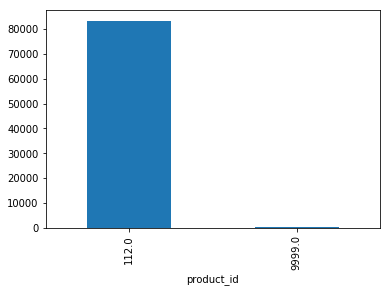

In [380]:
plot_count_per_id(transactions_tortel)

In [381]:
for i in transactions_tortel['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 112.0 
-
torteles                              82821
baguet multicereales                    437
ensaimadas piezas hacer a las 12 y      342
focaccias                               228
suizos piezas hacer las 12 y            209
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64



In [382]:
tortel = filter_tortel(unique_normalized_decriptions)

tortel['target_names_prod_by_prod'] = 'tortel'
list_of_dfs.append(tortel)
tortel.head(5)

product_id                           desc_normalized  \
2498749        112.0                                  torteles   
23338023      9999.0  encargo380 torteles cocido para las tres   
26699152       112.0              torteles para cartel 4 50 10   
26699153       112.0          torteles para miercoles 50 50 10   
26699154       112.0              torteles para verdes 7 50 10   

         target_names_prod_by_prod  
2498749                     tortel  
23338023                    tortel  
26699152                    tortel  
26699153                    tortel  
26699154                    tortel

#### 2.3.10 Matching: baguette

In [383]:
def filter_baguette (df):
    baguette = df[df['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()
    return baguette

In [384]:
transaction_baguette = filter_baguette(df_with_normalized_descriptions_transactions)

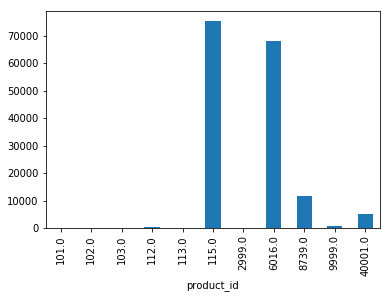

In [385]:
plot_count_per_id(transaction_baguette)

In [386]:
for i in transaction_baguette['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 115.0 
-
baguette mallorca                 47215
baguett mallorca                  28177
suizos piezas hacer a las 12 y       38
merengue blanco                      19
chapatitas                           19
Name: desc_normalized, dtype: int64

***Plotting id: 6016.0 
-
baguet piezas 5 hora         60306
baguet 5 la ana               7942
tartas pan torrijas andes       19
baguet multicereales            19
pan tostas tartas               19
Name: desc_normalized, dtype: int64

***Plotting id: 8739.0 
-
baguette mallorca integral    11552
lorena integral                9348
cold pan integral px             19
Name: desc_normalized, dtype: int64

***Plotting id: 103.0 
-
croissant petit                  94259
mini napolitanas crema            1824
mini napolitanas chocolate        1748
croissant normal petit            1216
croissant andes marcos piezas      380
Name: desc_normalized, dtype: int64

***Plotting id: 40001.0 
-
baguet    5149
Name: desc_normalized, dtype: 

Per client indications we take id = 115.0 containing baguette

In [387]:
baguette = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==115.0].copy()
baguette = baguette[baguette['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()

baguette['target_names_prod_by_prod'] = 'baguette'
list_of_dfs.append(baguette)
baguette.head(5)

product_id                          desc_normalized  \
2498751        115.0                         baguett mallorca   
27646722       115.0                        baguette mallorca   
22410863       115.0  baguette mallorca sin la bolsa mallorca   
11159206       115.0      baguette mallorcasin bolsa mallorca   
13115063       115.0                 baguette mallorca cocido   

         target_names_prod_by_prod  
2498751                   baguette  
27646722                  baguette  
22410863                  baguette  
11159206                  baguette  
13115063                  baguette

### Lets now concatenate results, merge them back to the  full list of normalized descriptions and evaluate its effectiveness

In [388]:
# Lets concatenate the results:
list_of_products_df = pd.concat(list_of_dfs, sort=False)

In [389]:
df_desc_normalezed_vs_prod_by_prod = pd.merge(df_with_normalized_descriptions_transactions, list_of_products_df,how='left',on=['desc_normalized','product_id'])

## Merging test:

In [390]:
#Control merge size:
if (df_with_normalized_descriptions_transactions.shape[0] == df_desc_normalezed_vs_prod_by_prod.shape[0] ): 
    test1 = "OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test1 = "ERROR - 'df' has NOT the same size as 'df_desc_normalezed_vs_prod_by_prod' "

print(test1)

OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 


*NOTE:*

During the first executions of code with the full transactions file, this error was failing; 'df' had less rows than 'df_with_normalized_descriptions_transactions'. The reason for this was not easy to identify, however digging we found that that in the normalized description two products descriptions ware naming two different products in the description, however this was not the case for the raw description (before the spell-cheacker):

for example:
- Normalized prod description: 'tarta mousse 3 chocolates de 20 raciones con escrito sobre la tarta manzana y mini felicidades'
- Raw description: 'TARTA MOUSSE 3 CHOCOLATES DE 20 RACIONES CON ESCRITO SOBRE LA TARTA:  MARIANA Y DANI FELICIDADES'

Basically, the spell-corrector was solving some problems; normalizing 'trata' , 'taaarta' under 'tarta', but adding a new one: normalizing words that it doesnt know, that may be a correct word, to a word that it knows: 'MARIANA' to 'manzana'... Ofcourse this is a weakness, however from the manual inspections that were performed, it doesnt seem to happen often.

How we solve it by adding to the bakery products dataset: 
- A list of the most common male and female spanish names: in order to avoid confusion in the names

sources of the datasets:
- spanish names:https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177009&menu=resultados&secc=1254736195454&idp=1254734710990


Also, in this case we added some names that we found to the excel; the right thing to do should we had more time, would be to polish the dataset, by adding not just mallorca catalogue and names, but also a book in spanish. Perhaps, it would also be interesting to applying NLP to identify NAMES from the product descriptions and add them to the products dataset...

### 2.5 Test that data has not been corrputed

To test the integrity of the data, the original dataset should be the same as the last dataset without that we added, in other words, without the columns with the normalized descriptuons, and the target names:

In [391]:
# First, lets check the size of both dataframes:
print("Original dataset shape: {}".format(df.shape))
print("Resulting dataset shape: {}".format(df_desc_normalezed_vs_prod_by_prod.shape))

Original dataset shape: (30550252, 6)
Resulting dataset shape: (30550252, 8)


The shape looks good, we were expecting the resulting dataset to have to columns more. Lets now evauate if they are actually the same dataset if we remove the added columns:

In [392]:
# Selecting original columnsd from the resulting df
df_result = df_desc_normalezed_vs_prod_by_prod.loc[:, df.columns]

In [393]:
# Now, lets compare it with the original dataset, sorting them out in the same way:
df_result_sorted = df_result.sort_values(by = ['order_date','store','description','product_id', 'units_ordered']).reset_index().drop('index', axis = 1)
df_original_sorted = df.sort_values(by = ['order_date','store','description',  'product_id', 'units_ordered']).reset_index().drop('index', axis = 1)

In [394]:
df_result_sorted.head()

product_id                                     description  \
0       615.0                               ALASKAS FRAMBUESA   
1       172.0                       1/2 PAN DE MOLDE ENVUELTO   
2      9999.0                 3 RACIONES DE ENSALADA DE CAPON   
3      9999.0                   3 RACIONES VERDURAS SALTEADAS   
4      3252.0  ACETATO 11 POOL                          NUEVO   

         order_date  section store units_ordered  
0  1/1/2008 0:00:00        0  AaUP          2,00  
1  1/1/2008 0:00:00        0  AaUP          0,00  
2  1/1/2008 0:00:00        0  AaUP          0,00  
3  1/1/2008 0:00:00        0  AaUP          0,00  
4  1/1/2008 0:00:00        0  AaUP          0,00

In [395]:
df_original_sorted.head()

product_id                                     description  \
0       615.0                               ALASKAS FRAMBUESA   
1       172.0                       1/2 PAN DE MOLDE ENVUELTO   
2      9999.0                 3 RACIONES DE ENSALADA DE CAPON   
3      9999.0                   3 RACIONES VERDURAS SALTEADAS   
4      3252.0  ACETATO 11 POOL                          NUEVO   

         order_date  section store units_ordered  
0  1/1/2008 0:00:00        0  AaUP          2,00  
1  1/1/2008 0:00:00        0  AaUP          0,00  
2  1/1/2008 0:00:00        0  AaUP          0,00  
3  1/1/2008 0:00:00        0  AaUP          0,00  
4  1/1/2008 0:00:00        0  AaUP          0,00

In [396]:
# Now that they have the same columns, and are sorted using the same criteria, lets evaluate if they are the same:
comparison_result = df_result_sorted.equals(df_original_sorted)

if comparison_result == True:
    test2 = 'OK - Original dataset is similar to the resulting dataset'
else:
     test2 ='ERROR - Original dataset NOT found'

print(test2)

OK - Original dataset is similar to the resulting dataset


### 2.6 Filter dataset to only include the products from the list provided by the client, and save to csv

In [413]:
df_target_products = df_desc_normalezed_vs_prod_by_prod[~df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]
# df_other_products = df_desc_normalezed_vs_prod_by_prod[df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]

In [414]:
df_target_products.head()

product_id        description        order_date  section store  \
216       100.0          CROISANTS  1/1/2008 0:00:00        0  VeUp   
234       182.0  PALMERAS DE TRUFA  1/1/2008 0:00:00        0  VeUp   
240       101.0          CROISSANT  1/1/2008 0:00:00        0  VeUp   
242       103.0    CROISSANT PETIT  1/1/2008 0:00:00        0  VeUp   
272       112.0           TORTELES  1/1/2008 0:00:00        0  VeUp   

    units_ordered   desc_normalized target_names_prod_by_prod  
216         20,00         croissant          croissant simple  
234          4,00  palmera de trufa         palmera chocolate  
240          0,00         croissant          croissant simple  
242         18,00   croissant petit           croissant petit  
272         60,00          torteles                    tortel

In [433]:
df_target_products['units_ordered'].isnull().values.any()

False

In [440]:
df_target_products['units_ordered'].str.contains(',').all()

True

In [419]:
df_target_products['units_ordered'].fillna(0.0, inplace=True)

In [441]:
from datetime import datetime as dttm

df_target_products['date']=df_target_products['order_date'].apply(lambda x: dttm.strptime(x,'%d/%m/%Y 0:00:00')).copy()

df_target_products['units_ordered_numeric']=df_target_products['units_ordered'].str.split(",").str[0].astype(dtype='float').copy()

df_target_products.drop('order_date', axis=1, inplace=True)

df_target_products.drop('units_ordered', axis=1, inplace=True)

df_target_products.rename(columns={'units_ordered_numeric':'units_ordered'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [442]:
df_target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 
df_target_products.to_csv(df_target_products_file_name, index = False, sep = ';' )
# df_target_products.head()

In [443]:
unfiltered_products_file_name = exit_path + 'unfiltered_transactions.csv' 
df_other_products.to_csv(unfiltered_products_file_name, index = False, sep = ';' )
df_other_products.head()

Unnamed: 0  product_id                            description  \
0        5905       203.0                       QUICHES DE QUESO   
1        5890       144.0                             HERRADURAS   
2        5891       157.0      PALMERITAS CHOCOLATE CAJA 275 GRS   
3        5892       158.0  PALMERITAS DE CHOCOLATE BOLSA 125 GRS   
4        5893       165.0                      CAKE DE ZANAHORIA   

          order_date  section store units_ordered  \
0  1/10/2013 0:00:00        0  BmUP         12,00   
1  1/10/2013 0:00:00        0  BmUP          0,00   
2  1/10/2013 0:00:00        0  BmUP          6,00   
3  1/10/2013 0:00:00        0  BmUP          6,00   
4  1/10/2013 0:00:00        0  BmUP          4,00   

                         desc_normalized target_names_prod_by_prod  
0                       quieres de queso                       NaN  
1                             herraduras                       NaN  
2       palmeritas chocolate caja 25 gas                       NaN  
3  palmeritas de chocolate bolsa 125 gas                       NaN  
4                      cafe de zanahoria                       NaN

# ERROR CONTROL

In [444]:
print(test0)
print(test1)
print(test2)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - Original dataset is similar to the resulting dataset
